In [1]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
import importlib
import statsmodels.api as sm
import pickle
import ground_truth_real

from toleranceinterval import twoside
from ground_truth_real import GroundTruthMeasurements
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.interpolate import UnivariateSpline
from scipy.stats import normaltest

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import PchipInterpolator

plt.style.use("seaborn-v0_8")
sns.set_palette(sns.color_palette("colorblind"))

### Import and process BEV and tracking poses

In [97]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
figures_dir = f'{os.getcwd()}/../../../../figures'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'
run3_path = f'{experiments_dir}/run3'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]
bev_paths_run3 = [f'{run3_path}/bev/{f}' for f in os.listdir(f'{run3_path}/bev') if os.path.isdir(f'{run3_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
tracking_paths_run3 = [f'{run3_path}/ego/{f}/color' for f in os.listdir(f'{run3_path}/ego') if os.path.isdir(f'{run3_path}/ego/{f}')]

RUN1_2_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-184.8,
  bev_to_cam_ego_y=-39.5,
  bev_to_cam_ego_z=12.5,
  bev_to_back_opp_x=-100.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-120.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 90, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

RUN3_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-28.7,
  bev_to_cam_ego_y=376.0,
  bev_to_cam_ego_z=-94.9,
  bev_to_back_opp_x=-157.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-116.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 0, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

k = twoside.normal_factor(1000, 0.95, 0.95)

In [10]:
importlib.reload(ground_truth_real)

<module 'ground_truth_real' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/ground_truth_real.py'>

In [184]:
smoothing_funcs = ["lowess"]
run1_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run1, tracking_paths_run1), RUN1_2_MEASUREMENTS, smoothing_funcs)
run2_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run2, tracking_paths_run2), RUN1_2_MEASUREMENTS, smoothing_funcs)
run3_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run3, tracking_paths_run3), RUN3_MEASUREMENTS, smoothing_funcs)

### Show the dictionary structure

In [185]:
def extract_keys(nested_dict):
  if not isinstance(nested_dict, dict):
    return None
  
  return {key: extract_keys(value) for key, value in nested_dict.items()}

result = extract_keys(run1_data[0])
result

{'start_time': None,
 'bev_path': None,
 'ego_path': None,
 'raw': {'ego_bev_right_df': None,
  'opp_bev_right_df': None,
  'ego_bev_left_df': None,
  'opp_bev_left_df': None,
  'ego_avg_bev_df': None,
  'rel_poses_left_df': None,
  'rel_poses_right_df': None,
  'rel_poses_avg_df': None,
  'poly': {'ego_bev_left_df': {'tx': None,
    'ty': None,
    'tz': None,
    'roll': None,
    'pitch': None,
    'yaw': None},
   'ego_bev_right_df': {'tx': None,
    'ty': None,
    'tz': None,
    'roll': None,
    'pitch': None,
    'yaw': None},
   'opp_bev_left_df': {'tx': None,
    'ty': None,
    'tz': None,
    'roll': None,
    'pitch': None,
    'yaw': None},
   'opp_bev_right_df': {'tx': None,
    'ty': None,
    'tz': None,
    'roll': None,
    'pitch': None,
    'yaw': None},
   'rel_poses_left_df': {'tx': None,
    'ty': None,
    'tz': None,
    'roll': None,
    'pitch': None,
    'yaw': None},
   'rel_poses_right_df': {'tx': None,
    'ty': None,
    'tz': None,
    'roll': None,
 

In [186]:
side_length = 0.25
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG

## Fit polynomial models to the BEV poses

In [187]:
class PolynomialParams:
  def __init__(self, df_name, x, y, degree):
    self.df_name = df_name
    self.x = x
    self.y = y
    self.degree = degree

def fit_polynomial_models(run_data, params: list[PolynomialParams], smoothing_type: str):
  for run in run_data:
    run[smoothing_type]["poly"] = {}

    for param in params:
      model, model_deriv, model_2nd_deriv = ground_truth_real.fit_polynomial(
        run[smoothing_type][param.df_name][param.x].values, 
        run[smoothing_type][param.df_name][param.y].values, param.degree)
      if param.df_name not in run[smoothing_type]["poly"]:
        run[smoothing_type]["poly"][param.df_name] = {}
      
      run[smoothing_type]["poly"][param.df_name][param.y] = (model, model_deriv, model_2nd_deriv)

poly_params = []

# Fit polynomial models for poses from BEV
for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if dim in ["tz", "roll", "pitch"]:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 1))
    else:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 12))

# Fit polynomial models for relative poses
for df_name in ["rel_poses_left_df", "rel_poses_right_df", "rel_poses_avg_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if dim == "tz":
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 1))
    else:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", dim, 12))

for smoothing_type in ["raw"] + smoothing_funcs:
  fit_polynomial_models(run1_data, poly_params, smoothing_type)
  fit_polynomial_models(run2_data, poly_params, smoothing_type)
  fit_polynomial_models(run3_data, poly_params, smoothing_type)

## Use PCHIP interpolation to interpolate the BEV poses

In [188]:
# import pchip interpolation
from scipy.interpolate import PchipInterpolator

class PchipParams:
  def __init__(self, df_name, x, y):
    self.df_name = df_name
    self.x = x
    self.y = y

def fit_pchip_interpolators(run_data, params: list[PchipParams], smoothing_type: str):
  for run in run_data:
    run[smoothing_type]["pchip"] = {}

    for param in params:
      model = PchipInterpolator(run[smoothing_type][param.df_name][param.x], run[smoothing_type][param.df_name][param.y])
      model_deriv = model.derivative()
      model_2nd_deriv = model.derivative(2)
      
      if param.df_name not in run[smoothing_type]["pchip"]:
        run[smoothing_type]["pchip"][param.df_name] = {}
      
      run[smoothing_type]["pchip"][param.df_name][param.y] = (model, model_deriv, model_2nd_deriv)

pchip_params = []

# Fit polynomial models for poses from BEV
for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    pchip_params.append(PchipParams(df_name, "time_norm (sec)", dim))

# Fit polynomial models for relative poses
for df_name in ["rel_poses_left_df", "rel_poses_right_df", "rel_poses_avg_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    pchip_params.append(PchipParams(df_name, "time_norm (sec)", dim))

for smoothing_type in ["raw"] + smoothing_funcs:
  fit_pchip_interpolators(run1_data, pchip_params, smoothing_type)
  fit_pchip_interpolators(run2_data, pchip_params, smoothing_type)
  fit_pchip_interpolators(run3_data, pchip_params, smoothing_type)

## Fit UnivariateSpline (B-Spline) to interpolate the BEV poses

In [241]:
# spline params
class SplineParams:
  def __init__(self, df_name, x, y, degree=3, smoothing_factor=0):
    self.df_name = df_name
    self.x = x
    self.y = y
    self.degree = degree
    self.smoothing_factor = smoothing_factor

def fit_spline(run_data, params: list[SplineParams], smoothing_type: str):
  for run in run_data:
    run[smoothing_type]["spline"] = {}

    for param in params:
      spline = UnivariateSpline(run[smoothing_type][param.df_name][param.x],
                                run[smoothing_type][param.df_name][param.y],
                                k=param.degree, s=param.smoothing_factor)
      spline_deriv = spline.derivative()
      spline_2nd_deriv = spline_deriv.derivative()

      if param.df_name not in run[smoothing_type]["spline"]:
        run[smoothing_type]["spline"][param.df_name] = {}
      
      run[smoothing_type]["spline"][param.df_name][param.y] = (spline, spline_deriv, spline_2nd_deriv)

spline_params = []
for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if dim == "tz":
      spline_params.append(SplineParams(df_name, "time_norm (sec)", dim, 3, 0))
    else:
      spline_params.append(SplineParams(df_name, "time_norm (sec)", dim, 4, 0))

# Fit B-spline for relative poses
for df_name in ["rel_poses_left_df", "rel_poses_right_df", "rel_poses_avg_df"]:
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if dim in ["roll", "pitch", "yaw"]:
      spline_params.append(SplineParams(df_name, "time_norm (sec)", dim, 3, 30))
    else:
      spline_params.append(SplineParams(df_name, "time_norm (sec)", dim, 3, 0.1))


for smoothing_type in ["raw"] + smoothing_funcs:
  fit_spline(run1_data, spline_params, smoothing_type)
  fit_spline(run2_data, spline_params, smoothing_type)
  fit_spline(run3_data, spline_params, smoothing_type)

## Plot the displacement, velocity, and acceleration from the models

<AxesSubplot: xlabel='Time (s)', ylabel='Acceleration (m/s^2)'>

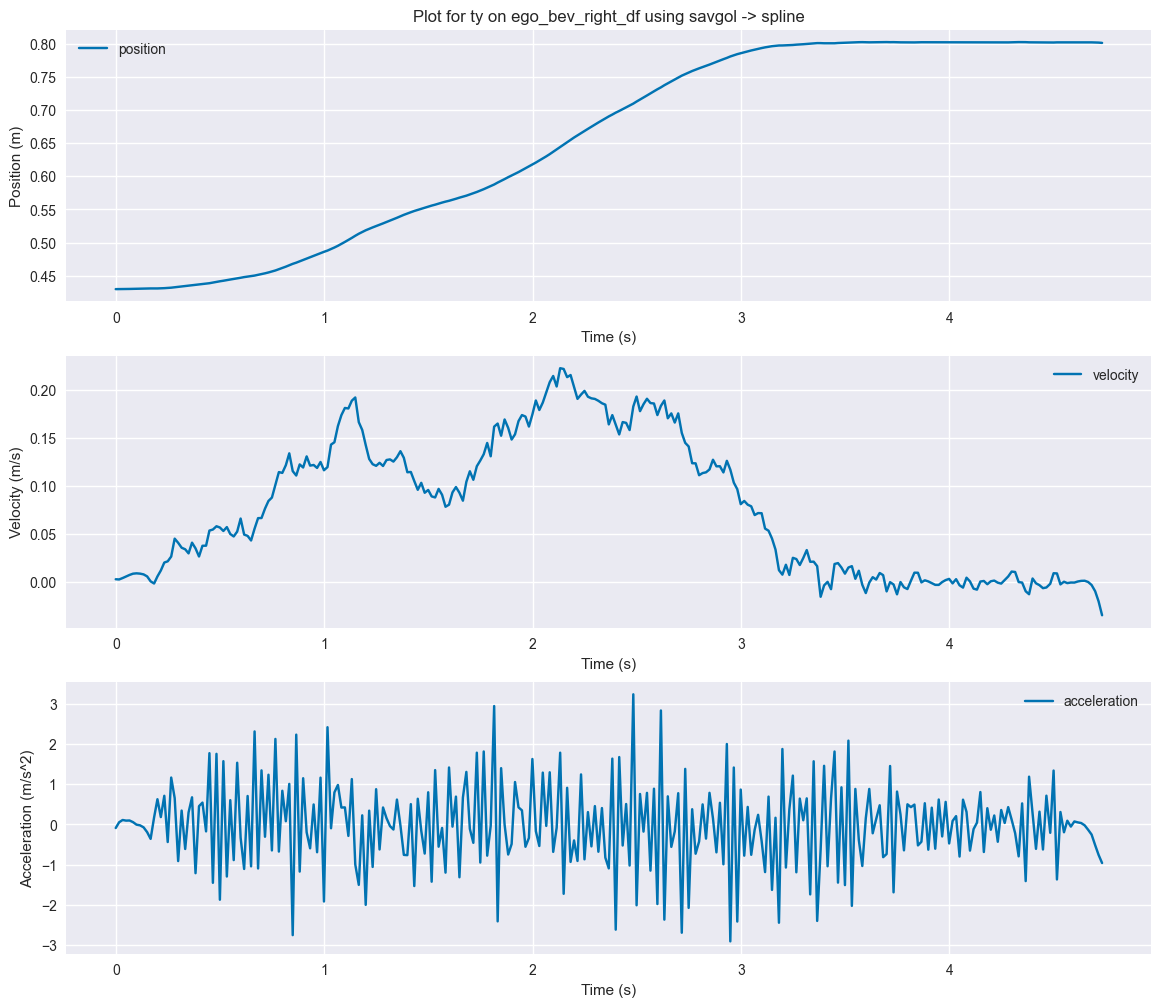

In [16]:
# Change these parameters to plot different data
smoothing_type = "savgol"
run_num = 6
run = run3_data[run_num][smoothing_type]
df_name = "ego_bev_right_df"
model_type = "spline"
y = "ty"

model, model_deriv, model_2nd_deriv = run[model_type][df_name][y]
# plot the data
plt.figure(figsize=(14, 12))

plt.tight_layout()

plt.subplot(3, 1, 1)
plt.title(f"Plot for {y} on {df_name} using {smoothing_type} -> {model_type}")
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
sns.lineplot(x=run[df_name]["time_norm (sec)"], y=model(run["ego_bev_right_df"]["time_norm (sec)"]), label='position')

plt.subplot(3, 1, 2)
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
sns.lineplot(x=run[df_name]["time_norm (sec)"], y=model_deriv(run["ego_bev_right_df"]["time_norm (sec)"]), label='velocity')

plt.subplot(3, 1, 3)
plt.ylabel('Acceleration (m/s^2)')
plt.xlabel('Time (s)')
sns.lineplot(x=run[df_name]["time_norm (sec)"], y=model_2nd_deriv(run["ego_bev_right_df"]["time_norm (sec)"]), label='acceleration')

In [29]:
importlib.reload(ground_truth_real)

<module 'ground_truth_real' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/ground_truth_real.py'>

In [191]:
run_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run3[6:7], tracking_paths_run3[6:7]), RUN3_MEASUREMENTS, smoothing_funcs)

In [192]:
from perception.scripts.ground_truth_real import generate_smoothed_data

run_data[0]["lowess"]["ego_bev_right_df"] = generate_smoothed_data(run_data[0]["raw"]["ego_bev_right_df"], 'lowess', frac=0.1)

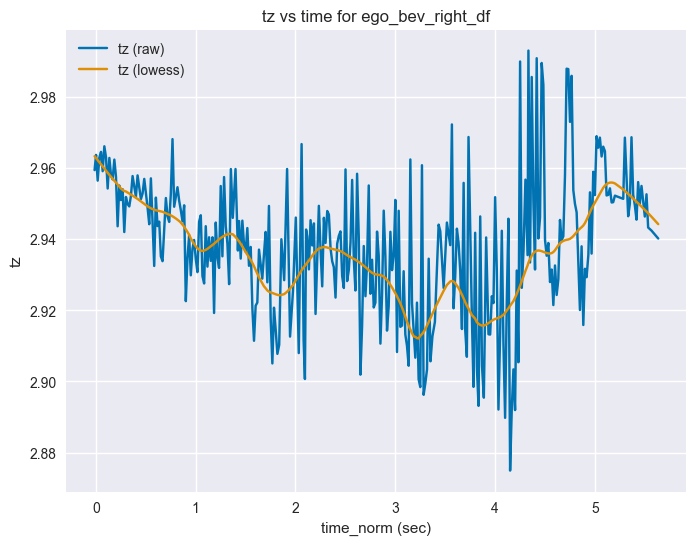

In [93]:
# plot the x and y positions
def plot_smoothed_data(run: dict, df_name: str, smoothing_types: list[str], x_col: str, y_col: str):
  for smoothing_type in smoothing_types:
    sns.lineplot(data=run[smoothing_type][df_name], x=x_col, y=f"{y_col}", label=f"{y_col} ({smoothing_type})")

def plot_all_smoothed_poses(run: dict, df_name, smoothing_types: list[str], x_col: str, columns: list[list[str]], figsize=(30, 15)):
  fig = plt.figure(figsize=figsize)
  # 2 rows, 3 columns
  rows = len(columns)
  cols = len(columns[0])
  flat_columns = np.array(columns).flatten()
  for i, col in enumerate(flat_columns):
    plt.subplot(rows, cols, i + 1)
    plot_smoothed_data(run, df_name, smoothing_types, x_col, col)
    plt.title(f"{col} vs time for {df_name}")
    plt.xlabel(x_col)
    plt.ylabel(col)
    plt.legend()


plot_all_smoothed_poses(
  run_data[0],
  "ego_bev_right_df",
  ["raw", "lowess"],
  "time_norm (sec)",
  [["tz"]],
  (8, 6)
)

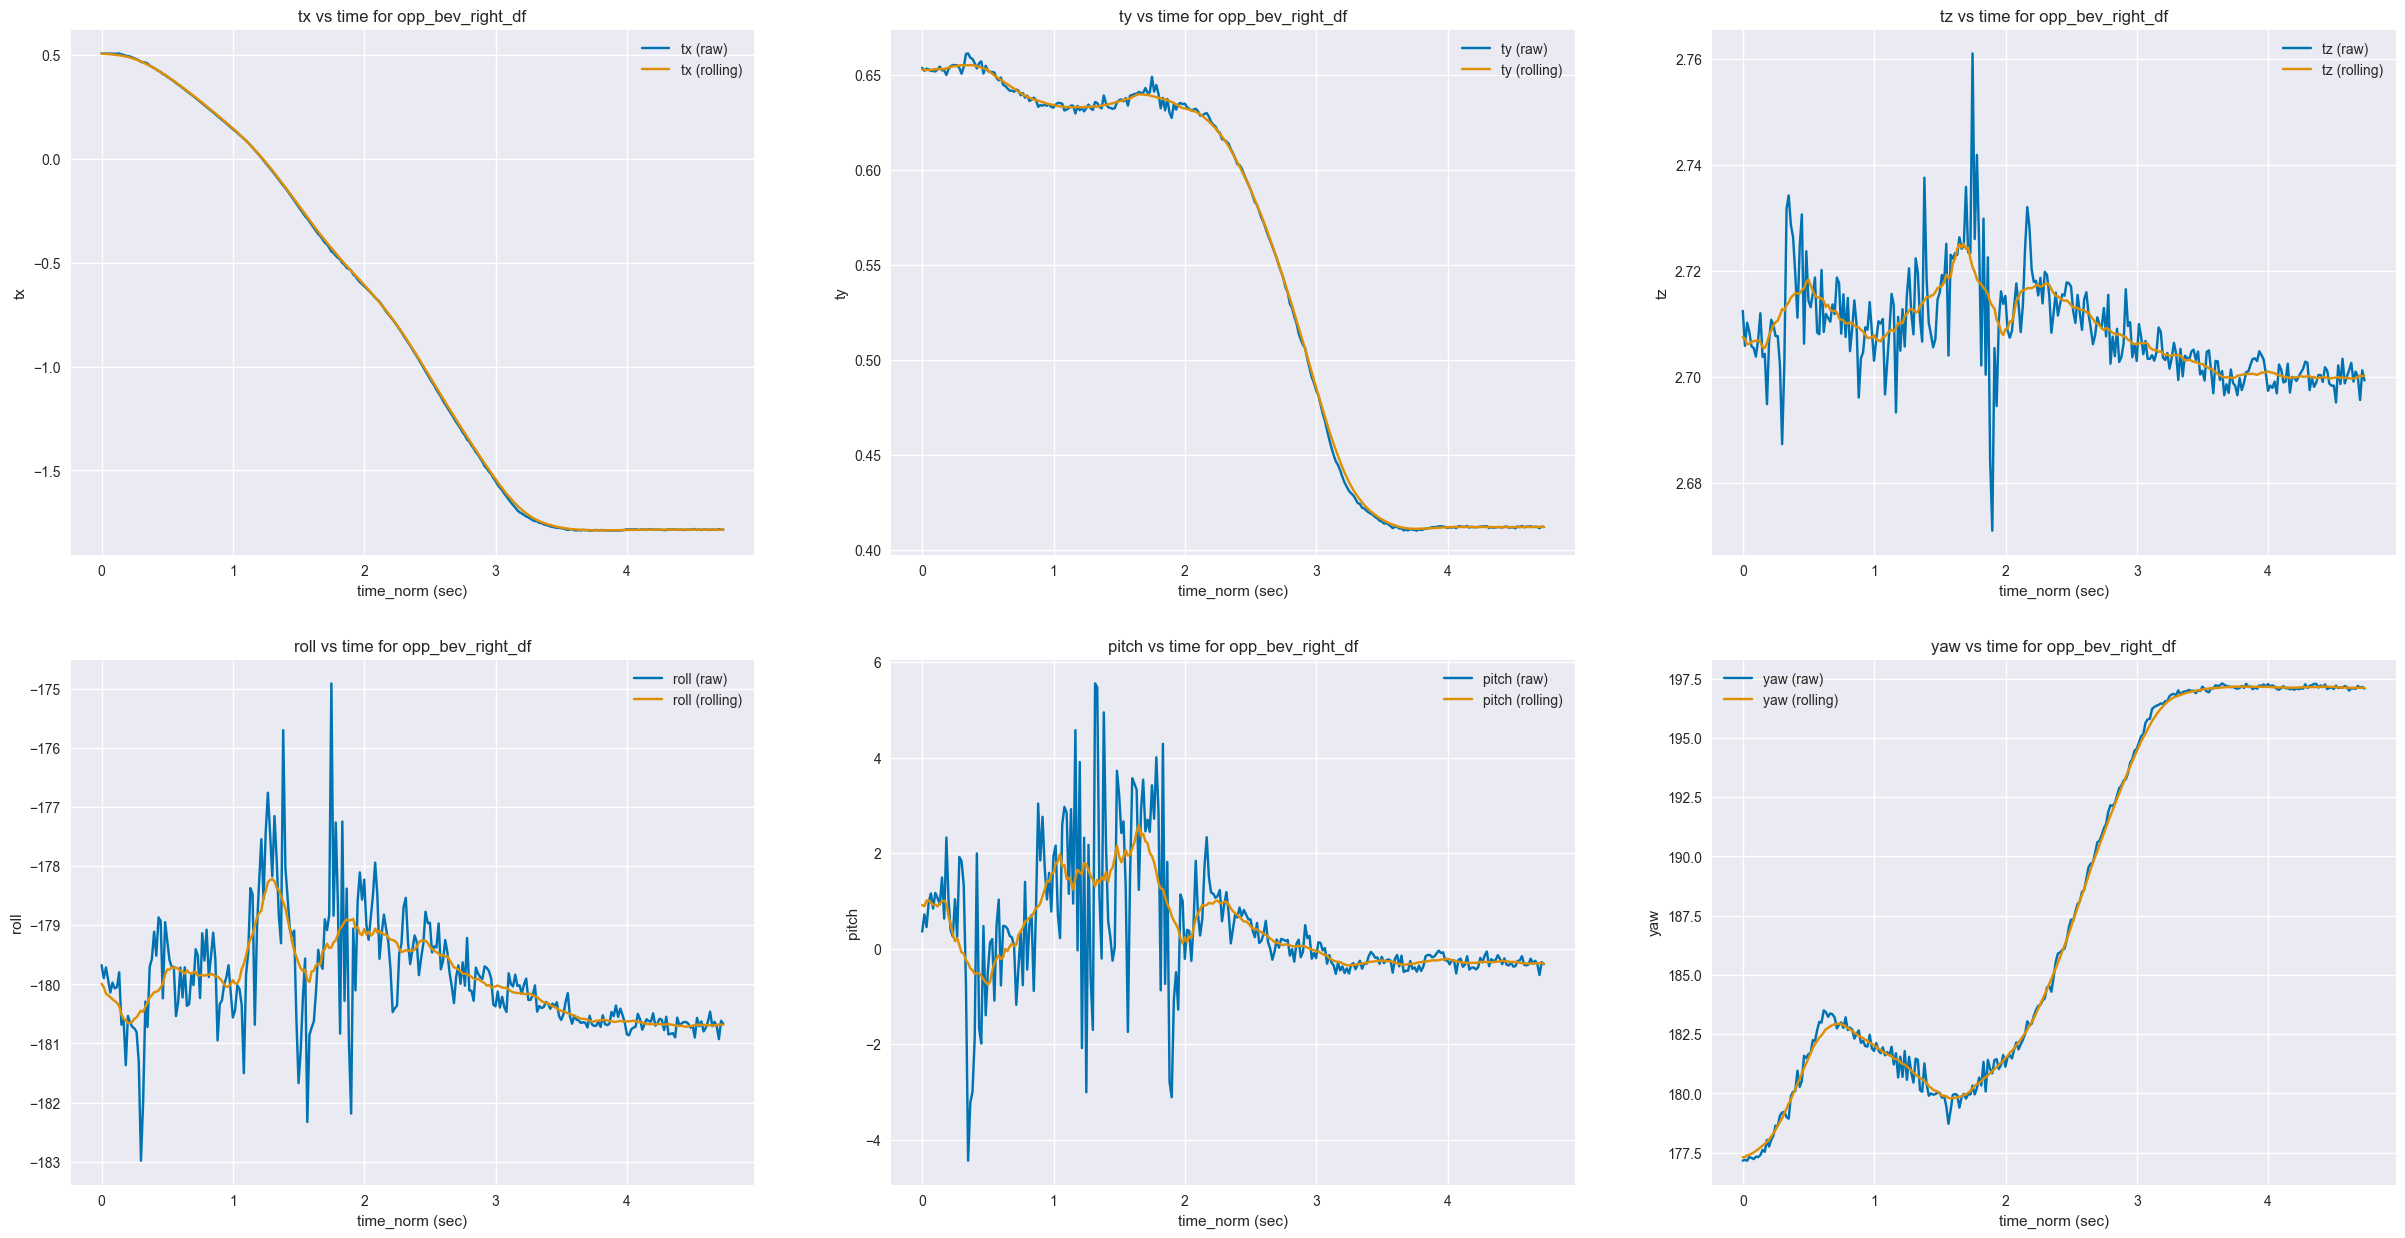

In [94]:
plot_all_smoothed_poses(
  run3_data[6],
  "opp_bev_right_df",
  ["raw", "rolling"],
  "time_norm (sec)",
  [["tx", "ty", "tz"], ["roll", "pitch", "yaw"]]
)

## Plot ground truth relative pose and tracking poses

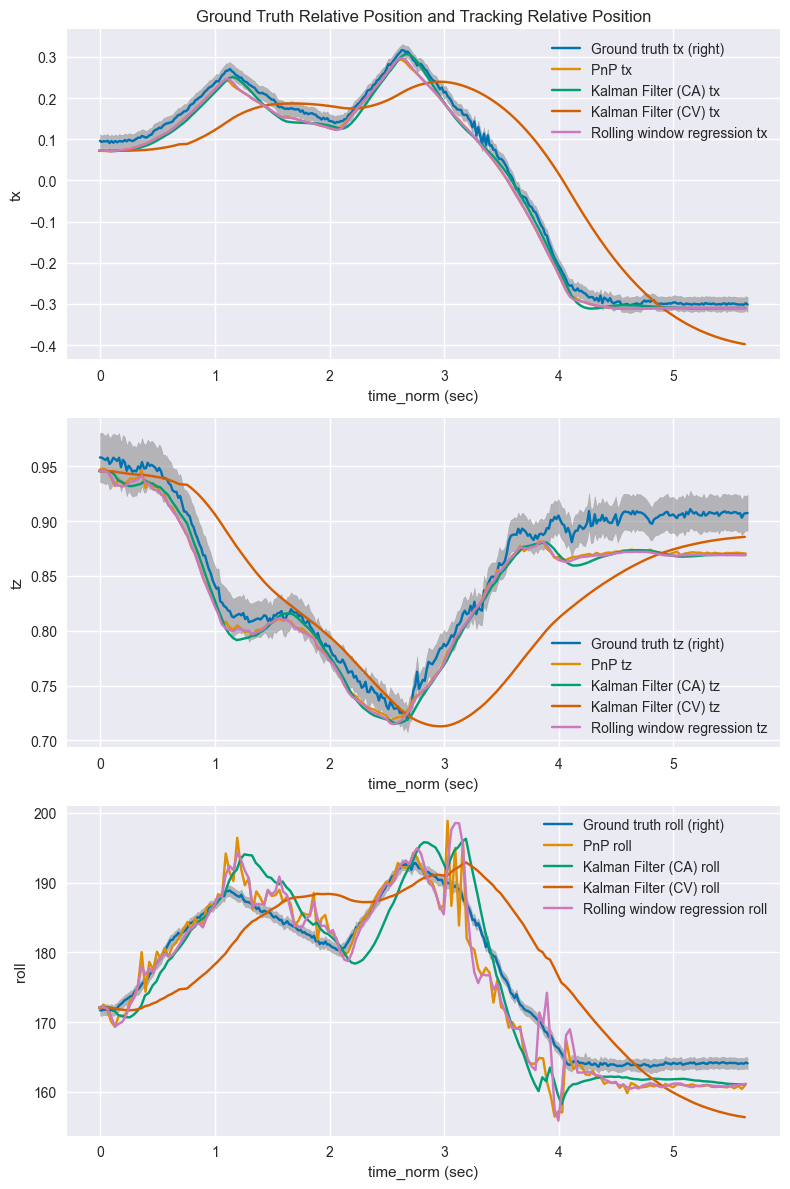

In [201]:
# plot the x and y positions
from perception.scripts import process_state_estimation

def plot_relative_position(run: dict, smoothing_type: str, 
  ground_truth_dfs: list[str], uncertainty_method: str, cols: list[str]):
  plt.figure(figsize=(8, 12))

  for i, col in enumerate(cols):
    ax = plt.subplot(len(cols), 1, i + 1)
    if i == 0:
      plt.title("Ground Truth Relative Position and Tracking Relative Position")
    
    # Plot ground truth relative positions
    for gt_name in ground_truth_dfs:
      sns.lineplot(data=run[smoothing_type][f"rel_poses_{gt_name}_df"], x="time_norm (sec)", y=col, label=f"Ground truth {col} ({gt_name})")
      if uncertainty_method == "tolerance":
        # plot uncertainty from tolerance interval
        plt.fill_between(run[f"monte_carlo_{gt_name}_df"]["time_norm (sec)"], 
                      run[smoothing_type][f"rel_poses_{gt_name}_df"][col] + k * run[f"monte_carlo_{gt_name}_df"][f"{col}_std"],
                      run[smoothing_type][f"rel_poses_{gt_name}_df"][col] - k * run[f"monte_carlo_{gt_name}_df"][f"{col}_std"], color='gray', alpha=0.5)
      elif uncertainty_method == "percentile":
        # plot uncertainty from percentile
        plt.fill_between(run[f"monte_carlo_{gt_name}_df"]["time_norm (sec)"], 
                      run[f"monte_carlo_{gt_name}_df"][f"{col}_2.5"],
                      run[f"monte_carlo_{gt_name}_df"][f"{col}_97.5"], color='gray', alpha=0.5)
      
    # Plot state estimation techniques
    sns.lineplot(data=run["tracking_df"], x="time_norm (sec)", y=col, label=f"PnP {col}")
    sns.lineplot(data=run["kalman_ca_df"], x="time_norm (sec)", y=col, label=f"Kalman Filter (CA) {col}")
    sns.lineplot(data=run["kalman_cv_df"], x="time_norm (sec)", y=col, label=f"Kalman Filter (CV) {col} ")
    sns.lineplot(data=run["rwr_df"], x="time_norm (sec)", y=col, label=f"Rolling window regression {col}")

  # save plot
  plt.tight_layout()
  # make transparent background
  plt.savefig(f"{figures_dir}/{run['bev_path'].split('/')[-1]}_{smoothing_type}_relative_position.png", transparent=True)

cols = ["tx", "tz", "roll"]
plot_relative_position(run3_data[4], "raw", ["right"], "tolerance", cols)

## Compute metrics for the runs

In [217]:
def compute_relative_pose_error(run, smoothing_type: str, model_type:str, 
  bev_cam: str, state_est_df_name: str, index_offset: int, uncertainty_method: str, k: float):

  # get the models for x,y,z,roll,pitch,yaw
  models = run[smoothing_type][model_type][f"rel_poses_{bev_cam}_df"]
  # get the state estimation df
  state_est_df = run[state_est_df_name].dropna()
  # print(state_est_df)
  # print(run["kalman_ca_df"])
  # for each time step, compute the pose using the model and create a df
  gt_poses_df = pd.DataFrame()
  gt_poses_diff_df = pd.DataFrame()
  for dim in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    model_func, _, _ = models[dim]
    gt_poses_df[dim] = model_func(state_est_df["time_norm (sec)"])

  state_est_diff_df = pd.DataFrame()
  gt_poses_diff_df["time_norm (sec)"] = state_est_df["time_norm (sec)"]
  state_est_diff_df["time_norm (sec)"] = state_est_df["time_norm (sec)"]

  results = []
  for i in range(index_offset, len(gt_poses_df)):
    gt_rot_curr = conv.get_rotation_matrix_from_euler(
      gt_poses_df.loc[i, "roll"], 
      gt_poses_df.loc[i, "pitch"], 
      gt_poses_df.loc[i, "yaw"], degrees=True
    )
    gt_rot_prev = conv.get_rotation_matrix_from_euler(
      gt_poses_df.loc[i - index_offset, "roll"], 
      gt_poses_df.loc[i - index_offset, "pitch"], 
      gt_poses_df.loc[i - index_offset, "yaw"], degrees=True
    )

    state_est_rot_curr = conv.get_rotation_matrix_from_euler(
      state_est_df.loc[i, "roll"], 
      state_est_df.loc[i, "pitch"], 
      state_est_df.loc[i, "yaw"], degrees=True
    )

    state_est_rot_prev = conv.get_rotation_matrix_from_euler(
      state_est_df.loc[i - index_offset, "roll"], 
      state_est_df.loc[i - index_offset, "pitch"], 
      state_est_df.loc[i - index_offset, "yaw"], degrees=True
    )
    # Get the ground truth and state estimation positions
    gt_pos_curr = np.array([gt_poses_df.loc[i, "tx"], gt_poses_df.loc[i, "ty"], gt_poses_df.loc[i, "tz"]])
    gt_pos_prev = np.array([gt_poses_df.loc[i - index_offset, "tx"], gt_poses_df.loc[i - index_offset, "ty"], gt_poses_df.loc[i - index_offset, "tz"]])
    state_est_pos_curr = np.array([state_est_df.loc[i, "tx"], state_est_df.loc[i, "ty"], state_est_df.loc[i, "tz"]])
    state_est_pos_prev = np.array([state_est_df.loc[i - index_offset, "tx"], state_est_df.loc[i - index_offset, "ty"], state_est_df.loc[i - index_offset, "tz"]])

    # get the relative transform between two consecutive time steps for both ground truth and state estimation
    gt_rel_pos, gt_rel_rot = gt_pos_curr - gt_pos_prev, gt_rot_prev.T @ gt_rot_curr
    state_est_rel_pos, state_est_rel_rot = state_est_pos_curr - state_est_pos_prev, state_est_rot_prev.T @ state_est_rot_curr
    
    # get the error for the relative transform of state estimation compared to ground truth
    gt_est_rel_rot = state_est_rel_rot.T @ gt_rel_rot
    gt_est_rel_pos = gt_rel_pos - state_est_rel_pos

    distance = np.linalg.norm(gt_est_rel_pos)
    angle_deg = np.arccos(min(1, max(-1, (np.trace(gt_est_rel_rot) - 1) / 2))) * 180 / np.pi

    results.append({
      "time_norm (sec)": state_est_df.loc[i, "time_norm (sec)"],
      "gt_rel_pos": gt_rel_pos,
      "gt_rel_rot": gt_rel_rot,
      "state_est_rel_pos": state_est_rel_pos,
      "state_est_rel_rot": state_est_rel_rot,
      "distance": distance,
      "angle": angle_deg,
    })
  return results

rel_pose_error = compute_relative_pose_error(
  run3_data[4], "raw", "pchip", "right", "rwr_df", 10, "tolerance", k
)


<AxesSubplot: xlabel='Time (s)', ylabel='Angle (degrees)'>

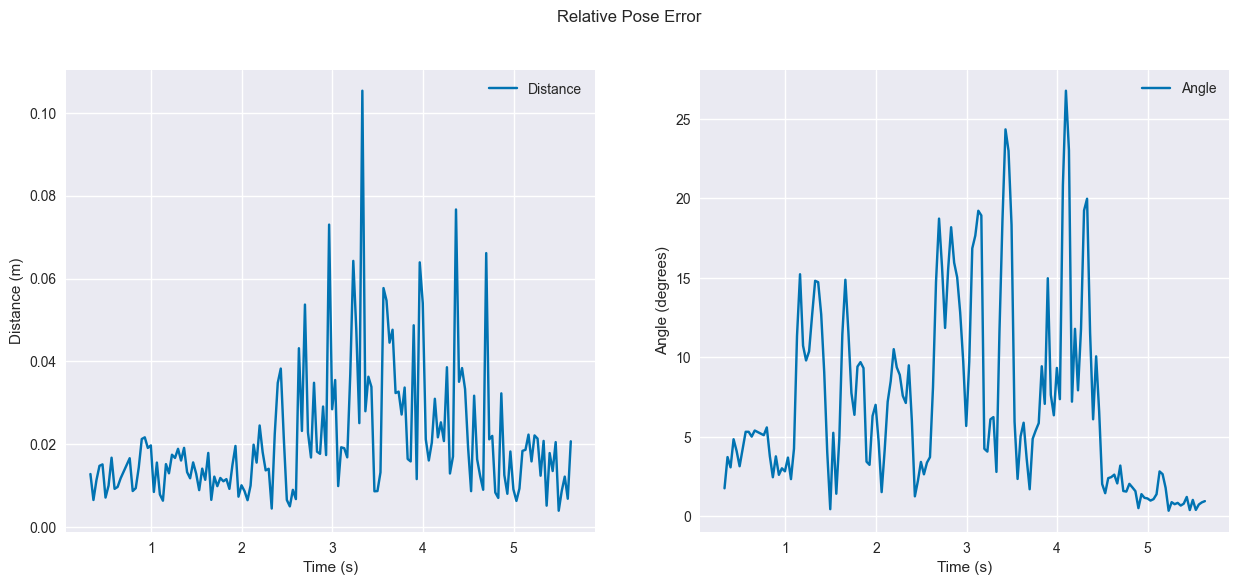

In [218]:
rel_pose_error_df = pd.DataFrame(rel_pose_error)
plt.figure(figsize=(15, 6))
plt.suptitle("Relative Pose Error")
plt.subplot(1, 2, 1)
plt.ylabel("Distance (m)")
plt.xlabel("Time (s)")
sns.lineplot(data=rel_pose_error_df, x="time_norm (sec)", y="distance", label="Distance")
plt.subplot(1, 2, 2)
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (s)")
sns.lineplot(data=rel_pose_error_df, x="time_norm (sec)", y="angle", label="Angle")


### Proportion of data that is within the tolerance interval

In [219]:
def compute_proportion_within_interval(run, smoothing_type: str, model_type:str, 
  cam: str, state_est_df: str, col: str, uncertainty_method: str, k: float):
  
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][col][0]
  mc_df = run[f"monte_carlo_{cam}_df"]

  # iterate through the state estimation data
  state_est_data = run[state_est_df]
  num_within_interval = 0
  for i, row in state_est_data.iterrows():
    # get index of the closest time step from the monte carlo data
    idx = np.argmin(np.abs(mc_df["time_norm (sec)"] - row["time_norm (sec)"]))
    norm_time = mc_df["time_norm (sec)"][idx]
    if uncertainty_method == "percentile":
      lower_diff = mc_df[f"{col}_mean"][idx] - mc_df[f"{col}_2.5"][idx]
      upper_diff = mc_df[f"{col}_97.5"][idx] - mc_df[f"{col}_mean"][idx]

      lower_bound = gt_model(norm_time) - lower_diff
      upper_bound = gt_model(norm_time) + upper_diff
    elif uncertainty_method == "tolerance":
      lower_bound = gt_model(norm_time) - k * mc_df[f"{col}_std"][idx]
      upper_bound = gt_model(norm_time) + k * mc_df[f"{col}_std"][idx]
    if row[col] >= lower_bound and row[col] <= upper_bound:
      num_within_interval += 1
  
  return num_within_interval / len(state_est_data)

compute_proportion_within_interval(run3_data[6], "raw", "pchip",
                                    "right", "kalman_ca_df", "tx", "tolerance", k)

0.18181818181818182

### Pearson correlation coefficient

In [220]:
def compute_pearson_correlation(run, smoothing_type: str, model_type: str, cam: str,
                                 state_est_df: str, dim: str, deriv: int):
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][deriv]
  
  if dim.startswith("t"):
    dim = dim[1:]

  if deriv == 0:
    if dim not in ("roll", "pitch", "yaw"):
      dim = f"t{dim}"
  elif deriv == 1:
    dim = f"v{dim}"
  else:
    dim = f"a{dim}"
    
  state_est_data = run[state_est_df]
  # get predicted values for the state estimation data
  gt_data = pd.DataFrame([{"time_norm (sec)": t, dim: float(gt_model(t))}\
                           for t in state_est_data["time_norm (sec)"]])
  return state_est_data[dim].corr(gt_data[dim])

compute_pearson_correlation(run3_data[6], "lowess", "spline", "right", "kalman_ca_df", "tx", 0), \
compute_pearson_correlation(run3_data[6], "raw", "pchip", "right", "kalman_ca_df", "tx", 0)

(0.99206834835078, 0.9944036478617099)

### MSE and RMSE (with ground truth uncertainty)

In [229]:
from typing import Literal

def get_derivative_name(dim: str, deriv: Literal["position", "velocity", "acceleration"]):
  if dim.startswith("t"):
    dim = dim[1:]

  if deriv == "position":
    if dim not in ("roll", "pitch", "yaw"):
      dim = f"t{dim}"
  elif deriv == "velocity":
    dim = f"v{dim}"
  else:
    dim = f"a{dim}"
  return dim

def get_derivative_num(deriv: Literal["position", "velocity", "acceleration"]):
  if deriv == "position":
    return 0
  elif deriv == "velocity":
    return 1
  else:
    return 2

def compute_mse(run, smoothing_type: str, model_type: str, cam: str, state_est_df: str, dim: str, deriv: Literal["position", "velocity", "acceleration"]):
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][get_derivative_num(deriv)]
  
  deriv_dim = get_derivative_name(dim, deriv)
  # gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][0]
  state_est_data = run[state_est_df]
  # get predicted values for the state estimation data
  gt_data = pd.DataFrame([{"time_norm (sec)": t, dim: float(gt_model(t))}\
                           for t in state_est_data["time_norm (sec)"]])
  return np.mean((state_est_data[deriv_dim] - gt_data[deriv_dim])**2)

def compute_rmse(run, smoothing_type: str, model_type: str, cam: str, state_est_df: str, dim: str, deriv: int):
  return np.sqrt(compute_mse(run, smoothing_type, model_type, cam, state_est_df, dim, deriv))

def compute_mse_with_ground_truth_uncertainty(run, smoothing_type: str, model_type: str, cam: str,
    state_est_df: str, dim: str, deriv: Literal["position", "velocity", "acceleration"], uncertainty_method: str, k: float):
  gt_model = run[smoothing_type][model_type][f"rel_poses_{cam}_df"][dim][get_derivative_num(deriv)]
  
  deriv_dim = get_derivative_name(dim, deriv)
    
  mc_df = run[f"monte_carlo_{cam}_df"]
  state_est_data = run[state_est_df]
  mse = 0

  # Use uncertainty propagation to estimate variance of velocity and acceleration
  mc_df = mc_df.copy()
  for c in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    mc_df[f"v{c.removeprefix('t')}_std"] = np.sqrt(mc_df[f"{c}_std"] ** 2 \
                                    + mc_df[f"{c}_std"].shift(1) ** 2)
    mc_df[f"a{c.removeprefix('t')}_std"] = np.sqrt(mc_df[f"v{c.removeprefix('t')}_std"] ** 2 \
                                    + mc_df[f"v{c.removeprefix('t')}_std"].shift(1) ** 2)

  non_nan_count = 0   
  for i, row in state_est_data.iterrows():
    # Get index of the closest time step from the Monte Carlo data
    idx = np.argmin(np.abs(mc_df["time_norm (sec)"] - row["time_norm (sec)"]))
    norm_time = mc_df["time_norm (sec)"][idx]

    if uncertainty_method == "percentile":
      lower_diff = mc_df[f"{deriv_dim}_mean"][idx] - mc_df[f"{dim}_2.5"][idx]
      upper_diff = mc_df[f"{deriv_dim}_97.5"][idx] - mc_df[f"{dim}_mean"][idx]

      lower_bound = gt_model(norm_time) - lower_diff
      upper_bound = gt_model(norm_time) + upper_diff
    elif uncertainty_method == "tolerance":
      
      if np.isnan(mc_df[f"{dim}_std"][idx]):
        continue
      lower_bound = gt_model(norm_time) - k * mc_df[f"{deriv_dim}_std"][idx]
      upper_bound = gt_model(norm_time) + k * mc_df[f"{deriv_dim}_std"][idx]
    
    # get minimum difference between bounds and the state estimation value
    mse += min((row[dim] - lower_bound)**2, (row[dim] - upper_bound)**2)
    non_nan_count += 1

  return mse / non_nan_count

def compute_rmse_with_ground_truth_uncertainty(run, smoothing_type: str, model_type: str, cam: str,
    state_est_df: str, dim: str, deriv: Literal["position", "velocity", "acceleration"], uncertainty_method: str, k: float):
  return np.sqrt(compute_mse_with_ground_truth_uncertainty(run, smoothing_type, model_type, cam,
    state_est_df, dim, deriv, uncertainty_method, k))

state_est_method = "kalman_ca_df"
run = run3_data[6]

compute_rmse(run, "raw", "pchip", "right", state_est_method, "tx", "position"), \
compute_rmse_with_ground_truth_uncertainty(run, "raw", "pchip", "right", 
  state_est_method, "tx", "position", "tolerance", k), \
compute_rmse_with_ground_truth_uncertainty(run, "raw", "pchip", "right", 
  state_est_method, "tz", "position", "tolerance", k), \
compute_rmse_with_ground_truth_uncertainty(run, "raw", "pchip", "right", 
  state_est_method, "roll", "position", "tolerance", k), \
compute_rmse_with_ground_truth_uncertainty(run, "lowess", "spline", "right", 
  state_est_method, "tx", "velocity", "tolerance", k), \
compute_rmse_with_ground_truth_uncertainty(run, "lowess", "spline", "right", 
  state_est_method, "tz", "velocity", "tolerance", k)

(0.039416727210321176,
 0.023970721277097713,
 0.022151863624517786,
 3.1373101659108693,
 nan,
 nan)

In [232]:
# get the RMSE for all dimensions
def compute_rmse_for_all_dimensions(run, smoothing_type: str, model_type: str, cam: str,
    state_est_df: str, deriv: Literal["position", "velocity", "acceleration"], dims: list[str]):
  rmses = []
  for dim in dims:
    rmses.append(compute_rmse_with_ground_truth_uncertainty(run, smoothing_type, model_type, cam,
      state_est_df, dim, deriv, "tolerance", k))
  return rmses

compute_rmse_for_all_dimensions(run3_data[6], "lowess", "spline", "right", state_est_method, "position", ["tx", "ty", "tz"])

[0.02286434589376237, 0.03943926343612304, 0.02111709388084104]

In [653]:
state_est_method = "kalman_cv_df"

compute_rmse_with_ground_truth_uncertainty(run3_data[6], "raw", "pchip", "right", 
  state_est_method, "tx", 0, "tolerance", k)

0.06643696790398315

## Plot BEV relative velocity models and estimated relative velocity from egovehicle

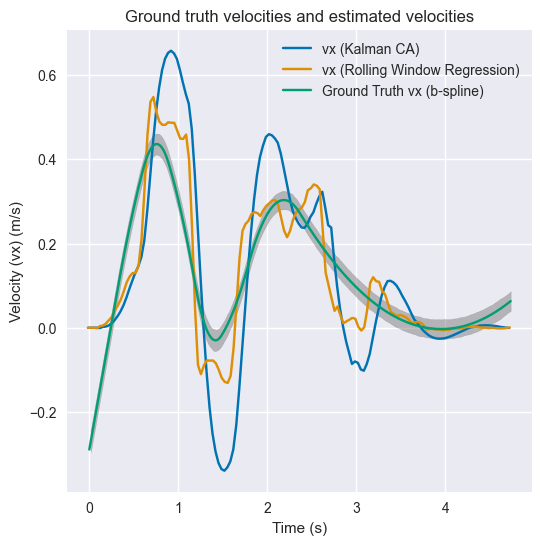

In [242]:
smoothing_type = "lowess"
run_num = 6
run = run3_data[run_num]
rel_poses_df_name = "rel_poses_right_df"
monte_carlo_df_name = "monte_carlo_right_df"

def plot_velocity(run: dict, smoothing_type: str, monte_carlo_df: str, rel_poses_df: str,
                   col: str, vel_col: str, figsize=(20, 20)):
  plt.figure(figsize=figsize)

  plt.title("Ground truth velocities and estimated velocities")
  plt.xlabel("Time (s)")
  plt.ylabel(f"Velocity ({vel_col}) (m/s)")

  # Use uncertainty propagation from the monte carlo to get uncertainty for velocity
  vel_error = run[monte_carlo_df].copy()
  for c in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    vel_error[f"{c}_std"] = np.sqrt(run[monte_carlo_df][f"{c}_std"] ** 2 \
                                    + run[monte_carlo_df][f"{c}_std"].shift(1) ** 2)
  poly_tx, poly_vx, poly_ax = run[smoothing_type]["poly"][rel_poses_df][col]
  spline_tx, spline_vx, spline_ax = run[smoothing_type]["spline"][rel_poses_df][col]
  pchip_tx, pchip_vx, pchip_ax = run[smoothing_type]["pchip"][rel_poses_df][col]

  # Polynomials overshoot at the beginning so we need to find the first zero crossing
  poly_vx_vals = np.polyval(poly_vx, run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"])
  poly_first_zero = min(np.argmax(poly_vx_vals > 0), np.argmax(poly_vx_vals < 0))

  spline_vx_vals = spline_vx(run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"])
  spline_first_zero = min(np.argmax(spline_vx_vals > 0), np.argmax(spline_vx_vals < 0))

  ### PLOT THE STATE ESTIMATION TECHNIQUES ###
  sns.lineplot(data=run["kalman_ca_df"], x="time_norm (sec)", y=vel_col, label=f"{vel_col} (Kalman CA)")
  # sns.lineplot(data=run["kalman_cv_df"], x="time_norm (sec)", y=vel_col, label=f"{vel_col} (Kalman CV)")
  sns.lineplot(data=run["rwr_df"], x="time_norm (sec)", y=vel_col, label=f"{vel_col} (Rolling Window Regression)")

  ### PLOT THE GROUND TRUTHS ###
  # sns.lineplot(x=run[smoothing_type][rel_poses_df]["time_norm (sec)"].iloc[poly_first_zero:], 
  #              y=poly_vx_vals[poly_first_zero:], label=f'{vel_col} (poly)')
  # plt.fill_between(run[monte_carlo_df]["time_norm (sec)"].iloc[poly_first_zero:],
  #                 poly_vx_vals[poly_first_zero:] + k * vel_error[f"{col}_std"].iloc[poly_first_zero:],
  #                 poly_vx_vals[poly_first_zero:] - k * vel_error[f"{col}_std"].iloc[poly_first_zero:], color='gray', alpha=0.5)
  sns.lineplot(x=run[smoothing_type][rel_poses_df]["time_norm (sec)"].iloc[spline_first_zero:],
               y=spline_vx_vals[spline_first_zero:], label=f"Ground Truth {vel_col} (b-spline)")
  plt.fill_between(run[monte_carlo_df]["time_norm (sec)"].iloc[spline_first_zero:],
                  spline_vx_vals[spline_first_zero:] + k * vel_error[f"{col}_std"].iloc[spline_first_zero:],
                  spline_vx_vals[spline_first_zero:] - k * vel_error[f"{col}_std"].iloc[spline_first_zero:], color='gray', alpha=0.5)
  # sns.lineplot(x=run[smoothing_type][rel_poses_df]["time_norm (sec)"],
  #               y=pchip_vx(run[smoothing_type][rel_poses_df]["time_norm (sec)"]), label=f'v_x ({smoothing_type} -> pchip)')

  plt.savefig(f"{figures_dir}/{run['bev_path'].split('/')[-1]}_{smoothing_type}_relative_velocity_{vel_col}.png", transparent=True)
  
plot_velocity(run, smoothing_type, monte_carlo_df_name, rel_poses_df_name, "tx", "vx", (6, 6))

In [ ]:
# compute the mean squared error of the velocity taking into account the uncertainty
def compute_velocity_mse(run: dict, smoothing_type: str, monte_carlo_df: str, rel_poses_df: str, col: str, vel_col: str):
  vel_error = run[monte_carlo_df].copy()
  for c in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    vel_error[f"{c}_std"] = np.sqrt(run[monte_carlo_df][f"{c}_std"] ** 2 \
                                    + run[monte_carlo_df][f"{c}_std"].shift(1) ** 2)
  poly_tx, poly_vx, poly_ax = run[smoothing_type]["poly"][rel_poses_df][col]
  spline_tx, spline_vx, spline_ax = run[smoothing_type]["spline"][rel_poses_df][col]
  pchip_tx, pchip_vx, pchip_ax = run[smoothing_type]["pchip"][rel_poses_df][col]

  # Polynomials overshoot at the beginning so we need to find the first zero crossing
  poly_vx_vals = np.polyval(poly_vx, run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"])
  poly_first_zero = max(np.argmax(poly_vx_vals > 0), np.argmax(poly_vx_vals < 0))

  spline_vx_vals = spline_vx(run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"])
  spline_first_zero = max(np.argmax(spline_vx_vals > 0), np.argmax(spline_vx_vals < 0))

  # Compute the mean squared error
  poly_mse = np.mean((poly_vx_vals[poly_first_zero:] - run[smoothing_type]["rel_poses_right_df"][vel_col].iloc[poly_first_zero:]) ** 2)
  spline_mse = np.mean((spline_vx_vals[spline_first_zero:] - run[smoothing_type]["rel_poses_right_df"][vel_col].iloc[spline_first_zero:]) ** 2)
  pchip_mse = np.mean((pchip_vx(run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"]) - run[smoothing_type]["rel_poses_right_df"][vel_col]) ** 2)
  return poly_mse, spline_mse, pchip_mse

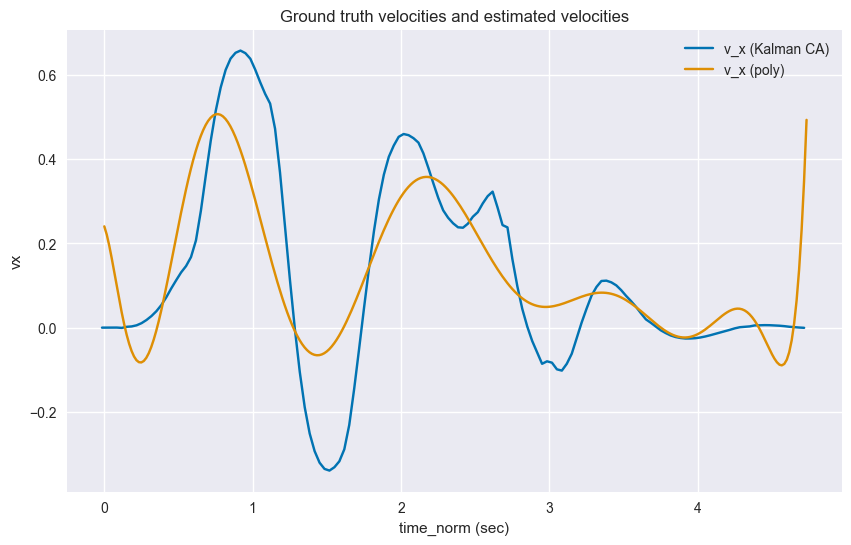

In [235]:
smoothing_type = "raw"
run_num = 6
run = run3_data[run_num]
df_name = "ego_bev_right_df"
y = "tx"

def plot_velocity(run: dict, figsize=(20, 20)):
  plt.figure(figsize=figsize)

  plt.title("Ground truth velocities and estimated velocities")

  # get ground truth from spline
  # plt.xlim(0, 4)
  # plt.ylim(-1, 1)
  poly_tx, poly_vx, poly_ax = run[smoothing_type]["poly"]["rel_poses_right_df"]["tx"]
  spline_tx, spline_vx, spline_ax = run[smoothing_type]["spline"]["rel_poses_right_df"]["tx"]
  lowess_pchip_tx, lowess_pchip_vx, lowess_pchip_ax = run["lowess"]["pchip"]["rel_poses_avg_df"]["tx"]

  # plot the spline_vx
  sns.lineplot(data=run["kalman_ca_df"], x="time_norm (sec)", y="vx", label="v_x (Kalman CA)")
  # sns.lineplot(data=run["kalman_cv_df"], x="time_norm (sec)", y="vx", label="v_x (Kalman CV)")
  # sns.lineplot(data=run["rwr_df"], x="time_norm (sec)", y="vx", label="v_x (RWR)")
  # sns.lineplot(data=test, x="time_norm (sec)", y="vx", label=f"Kalman Filter v_x (filtered)")

  sns.lineplot(x=run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"], 
               y=np.polyval(poly_vx, run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"]), label='v_x (poly)')
  # sns.lineplot(x=run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"],
  #              y=spline_vx(run[smoothing_type]["rel_poses_right_df"]["time_norm (sec)"]), label='v_x (b-spline)')
  
plot_velocity(run, (10, 6))